In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import math
import json
import datetime

import numpy as np
import pandas as pd
import networkx as nx

from nltk.corpus import stopwords

import matplotlib.pyplot as plt

In [3]:
community_df = pd.read_csv("retweets_communities_2018.csv")
communities = set(community_df.community)
known_users = set()

community_map = {x:[] for x in communities}
for idx, row in community_df.iterrows():
    community_map[row.community].append(row.user)
    known_users.add(row.user)

In [4]:
inv_community_map = {}
for idx, row in community_df.iterrows():
    inv_community_map[row.user] = row.community

In [5]:
target_communities = [
    995999075030982656, #restoration, climate action, climate change, and American left content
    471271042, #plant4pakistan
    40955185, #mostly around climate change and UN agencies
    40001204, #centered on mongabay and climate change
]

In [6]:
target_users = set([uid for c in target_communities for uid in community_map[c]])
print("Target User Count:", len(target_users))

Target User Count: 17955


In [7]:
def str_to_json(json_str):    
    try:
        tweet = json.loads(json_str)
        tweet["_json"] = json_str
        
        return tweet
    except ValueError as ve:
        return None

In [ ]:
rdd = sc.textFile("wri/data/stream_0{1,3,4}/statuses.*.gz")
tweets_ = rdd.map(str_to_json).filter(lambda t: t != None and len(t) > 0)
tweets = tweets_.map(lambda t: (t["id"], t)).reduceByKey(lambda l, r: l).map(lambda tup: tup[1])

In [ ]:
target_user_broad = sc.broadcast(target_users)
rel_tweets = tweets.filter(lambda t: t["user"]["id"] in target_user_broad.value)

In [ ]:
rel_tweets.map(lambda tweet: tweet["_json"]).saveAsTextFile("wri/2018_community_filtered")

In [8]:
rdd = sc.textFile("wri/2018_community_filtered")
rel_tweets = rdd.map(str_to_json).filter(lambda t: t != None and len(t) > 0)

In [9]:
# Twitter's time format, for parsing the created_at date
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"

epoch = datetime.datetime(1970,1,1)

def status_to_map(status):
    return {
        "id": status["user"]["id"],
        "screen_name": status["user"]["screen_name"],
        "time": (datetime.datetime.strptime(status["created_at"], timeFormat) - epoch).total_seconds()
    }

In [11]:
def retweet_edges(tweet):
    edges = []
    if ( "retweeted_status" in tweet ):
        edges.append((status_to_map(tweet), status_to_map(tweet["retweeted_status"])))
    return edges
edges = rel_tweets.flatMap(retweet_edges).collect()

In [12]:
# We'll use a directed graph since mentions/retweets are directional
graph = nx.DiGraph()

for source, sink in edges:
    source_id = int(source["id"])
    sink_id = int(sink["id"])
    
    source_time = source["time"]
    
    if ( graph.has_node(source_id) == False ):
        graph.add_node(source_id, community=int(inv_community_map[source_id]), screen_name=source["screen_name"])
    if ( graph.has_node(sink_id) == False ):
        graph.add_node(sink_id, community=int(inv_community_map.get(sink_id, -1)), screen_name=sink["screen_name"])

    if ( graph.has_edge(source_id, sink_id)):
        graph[source_id][sink_id]["weight"] += 1
        
        if ( source_time < graph[source_id][sink_id]["start"] ):
            graph[source_id][sink_id]["start"] = source_time
        
        if ( source_time > graph[source_id][sink_id]["end"] ):
            graph[source_id][sink_id]["end"] = source_time
    else:
        graph.add_edge(source_id, sink_id, weight=1, start=source_time, end=source_time)

In [13]:
len(graph.edges()), len(graph.nodes())

(77508, 23132)

In [32]:
for n, node_data in graph.nodes(data=True):    
    start_time = None
    end_time = None
    for source, sink, edge_data in graph.edges_iter(n, data=True):
        if ( start_time == None ):
            start_time = edge_data["start"]
            end_time = edge_data["end"]
        else:
            start_time = min(start_time, edge_data["start"])
            end_time = max(end_time, edge_data["end"])
        
    if ( start_time == None ):
        node_data["start"] = 0.0
        node_data["end"] = 0.0
    else:
        node_data["start"] = start_time
        node_data["end"] = end_time

In [25]:
major_density = nx.density(graph)
print("Graph Density:", major_density)

Graph Density: 0.0001448568171063185


In [ ]:
# THis may take a while
pageRankList = nx.pagerank_numpy(graph)
highRankNodes = sorted(pageRankList.keys(), key=pageRankList.get, reverse=True)
for x in highRankNodes[:10]:
    print (x, pageRankList[x])

In [33]:
nx.write_graphml(graph, "retweet_relevant_graph.graphml")

In [10]:
def tweet_to_text(tweet):
    tweet_text = tweet["text"].lower()
    if "retweeted_status" in tweet:
        tweet_text += " " + tweet["retweeted_status"]["text"].lower()
    return tweet_text
tokens = rel_tweets.map(lambda t: tweet_to_text(t)).collect()

In [11]:
from wordcloud import WordCloud

In [12]:
stops = [
    "rt",
    "http",
    "https",
    "co",
]

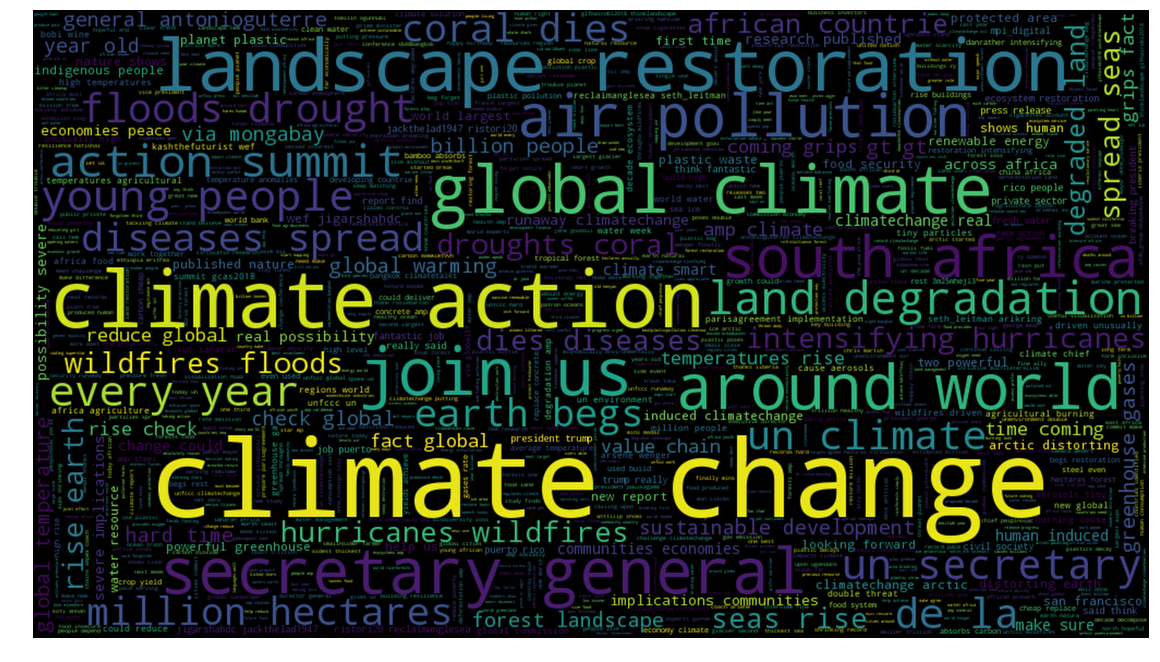

In [22]:
# lower max_font_size
wordcloud = WordCloud(
    background_color="black", 
    width=1024,
    height=576,
    stopwords=stopwords.words("english") + stops, 
    max_words=2000)

wordcloud.generate(" ".join(tokens))

# store to file
wordcloud.to_file("wordcloud_nairobi2018.pdf")

plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bessel")
plt.axis("off")
plt.savefig("wordcloud_v2.pdf", format="pdf")
plt.show()